<a href="https://colab.research.google.com/github/priyank206/Deep-Learning-Digital-Assignment/blob/main/Deep_Learning_DA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Define paths for train and test directories
train_dir = '/content/drive/My Drive/Datasets/Brain Tumor Classification (MRI)/Training'
test_dir = '/content/drive/My Drive/Datasets/Brain Tumor Classification (MRI)/Testing'

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

# Only rescale for testing
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Generate batches of images from the directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 394 images belonging to 4 classes.


In [6]:
# Load ResNet50 model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Complete model
transfer_learning_model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
transfer_learning_model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
# Train the model and validate on the test set
transfer_learning_history = transfer_learning_model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


74/74 ━━━━━━━━━━━━━━━━━━━━ 964s 12s/step - accuracy: 0.3564 - loss: 1.6104 - val_accuracy: 0.2766 - val_loss: 1.6009
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 512s 7s/step - accuracy: 0.4873 - loss: 1.1523 - val_accuracy: 0.3147 - val_loss: 2.1465
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 540s 7s/step - accuracy: 0.5096 - loss: 1.0874 - val_accuracy: 0.2563 - val_loss: 2.2899
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 487s 7s/step - accuracy: 0.4943 - loss: 1.1281 - val_accuracy: 0.2792 - val_loss: 1.9613
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 506s 7s/step - accuracy: 0.5587 - loss: 1.0317 - val_accuracy: 0.2817 - val_loss: 2.3393
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 489s 7s/step - accuracy: 0.5775 - loss: 0.9761 - val_accuracy: 0.2919 - val_loss: 2.1873
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 489s 7s/step - accuracy: 0.5877 - loss: 0.9695 - val_accuracy: 0.3223 - val_loss: 2.1078
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 490s 7s/step - accuracy: 0.5835 - loss: 0.9505 - val_accuracy: 0.3426 - val_loss: 2

In [18]:
# Define paths to save both models and histories in Google Drive
cnn_model_save_path = '/content/drive/My Drive/Datasets/Brain Tumor Classification (MRI)/cnn_brain_tumor_model.keras'
cnn_history_save_path = '/content/drive/My Drive/Datasets/Brain Tumor Classification (MRI)/cnn_training_history.json'
transfer_model_save_path = '/content/drive/My Drive/Datasets/Brain Tumor Classification (MRI)/transfer_brain_tumor_model.keras'
transfer_history_save_path = '/content/drive/My Drive/Datasets/Brain Tumor Classification (MRI)/transfer_training_history.json'

In [19]:
import json
transfer_learning_model.save(transfer_model_save_path)
with open(transfer_history_save_path, 'w') as f:
    json.dump(transfer_learning_history.history, f)

In [ ]:
from tensorflow.keras.models import load_model
import json

transfer_learning_model = load_model(transfer_model_save_path)


# Load history from a JSON file
with open(transfer_history_save_path, 'r') as file:
    transfer_learning_history = json.load(file)


13/13 ━━━━━━━━━━━━━━━━━━━━ 105s 8s/step
Classification Report:

                  precision    recall  f1-score   support

    glioma_tumor       0.42      0.11      0.17       100
meningioma_tumor       0.28      0.17      0.21       115
        no_tumor       0.29      0.77      0.42       105
 pituitary_tumor       0.52      0.15      0.23        74

        accuracy                           0.31       394
       macro avg       0.38      0.30      0.26       394
    weighted avg       0.36      0.31      0.26       394



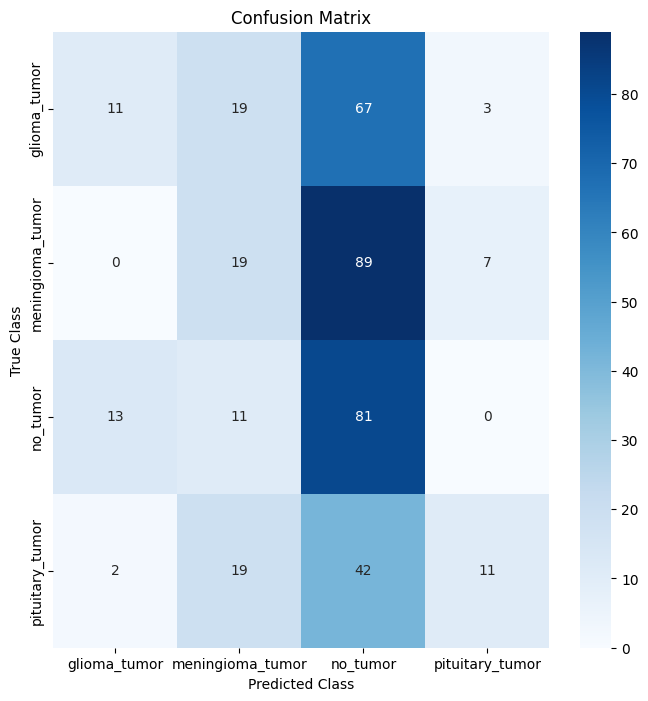

In [22]:
# Make predictions on the test data
test_generator.reset()
predictions = transfer_learning_model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Print classification report
print("Classification Report:\n")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()


In [23]:
!pip install scikit-learn # Install scikit-learn if you haven't already
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Make predictions on the test set
test_generator.reset()
predictions = transfer_learning_model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Calculate precision, recall, and F1-score
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Print detailed classification report
print("\nDetailed Classification Report:\n")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

13/13 ━━━━━━━━━━━━━━━━━━━━ 68s 5s/step
Precision: 0.3647
Recall: 0.3096
F1 Score: 0.2608

Detailed Classification Report:

                  precision    recall  f1-score   support

    glioma_tumor       0.42      0.11      0.17       100
meningioma_tumor       0.28      0.17      0.21       115
        no_tumor       0.29      0.77      0.42       105
 pituitary_tumor       0.52      0.15      0.23        74

        accuracy                           0.31       394
       macro avg       0.38      0.30      0.26       394
    weighted avg       0.36      0.31      0.26       394



In [26]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define image dimensions (replace with your actual image dimensions)
img_height = 224  # Updated height to match the input shape
img_width = 224   # Updated width to match the input shape

# Build the CNN model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # Assuming 4 classes for tumor types
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 20
cnn_history = cnn_model.fit(train_generator, epochs=epochs, validation_data=test_generator)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 315s 4s/step - accuracy: 0.3807 - loss: 1.3667 - val_accuracy: 0.3376 - val_loss: 1.9191
Epoch 2/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 297s 4s/step - accuracy: 0.5300 - loss: 0.9961 - val_accuracy: 0.3629 - val_loss: 1.8962
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 300s 4s/step - accuracy: 0.6126 - loss: 0.8326 - val_accuracy: 0.3883 - val_loss: 2.1979
Epoch 4/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 320s 4s/step - accuracy: 0.6156 - loss: 0.8365 - val_accuracy: 0.4112 - val_loss: 2.3934
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 298s 4s/step - accuracy: 0.6418 - loss: 0.7765 - val_accuracy: 0.3807 - val_loss: 2.5957
Epoch 6/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 323s 4s/step - accuracy: 0.6630 - loss: 0.7018 - val_accuracy: 0.3959 - val_loss: 2.7984
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 309s 4s/step - accuracy: 0.7120 - loss: 0.6489 - val_accuracy: 0.3883 - val_loss: 2.7809
Epoch 8/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 311s 4s/step - accuracy: 0.6953 - loss: 0.6520 - val_accuracy: 0.4518 - v

In [30]:
cnn_model.save(cnn_model_save_path)
with open(cnn_history_save_path, 'w') as f:
    json.dump(cnn_history, f)

In [31]:
from tensorflow.keras.models import load_model
import json

cnn_model = load_model(cnn_model_save_path)


# Load history from a JSON file
with open(cnn_history_save_path, 'r') as file:
    cnn_history = json.load(file)


In [32]:
!pip install scikit-learn # Install scikit-learn if you haven't already
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Make predictions on the test set
test_generator.reset()
predictions = cnn_model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Calculate precision, recall, and F1-score
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Print detailed classification report
print("\nDetailed Classification Report:\n")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step
Precision: 0.6862
Recall: 0.5254
F1 Score: 0.5017

Detailed Classification Report:

                  precision    recall  f1-score   support

    glioma_tumor       0.73      0.19      0.30       100
meningioma_tumor       0.78      0.44      0.57       115
        no_tumor       0.39      1.00      0.56       105
 pituitary_tumor       0.89      0.43      0.58        74

        accuracy                           0.53       394
       macro avg       0.70      0.52      0.50       394
    weighted avg       0.69      0.53      0.50       394

